# MountainCar-SHAP Experiment: XRL with SHAP

## 목적
SHAP (SHapley Additive exPlanations)를 사용하여 MountainCar 에이전트의 의사결정 과정을 분석하고, IG와의 차이점을 이해합니다.

## SHAP vs IG
- **IG (Integrated Gradients)**: Gradient 기반, 빠르지만 feature 간 상호작용 파악 어려움
- **SHAP**: 게임 이론 기반, 느리지만 각 feature의 공정한(fair) 기여도 측정 가능

## 실험 내용
1. DQN 에이전트 학습 (MountainCar-v0)
2. SHAP으로 feature 중요도 분석
3. 위치별, 속도별 의사결정 패턴 분석
4. Waterfall plot, Force plot 등 다양한 시각화
5. IG 결과와 비교

## 1. 라이브러리 임포트

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import shap
from collections import deque
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 재현성을 위한 시드 설정
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("라이브러리 임포트 완료!")
print(f"PyTorch 버전: {torch.__version__}")
print(f"SHAP 버전: {shap.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

라이브러리 임포트 완료!
PyTorch 버전: 2.8.0+cu126
SHAP 버전: 0.49.1
Device: cuda


## 2. MountainCar 환경 이해

**MountainCar-v0 환경:**
- **목표**: 언덕 사이 골짜기의 자동차를 오른쪽 목표 지점(깃발)까지 도달시키기
- **문제**: 자동차 엔진 파워가 약해서 한 번에 올라갈 수 없음 → 좌우로 왔다갔다 하며 가속도를 얻어야 함

**State (관측값) - 2차원:**
- `position`: 자동차 위치 [-1.2, 0.6] (0.5가 목표)
- `velocity`: 자동차 속도 [-0.07, 0.07]

**Action - 3가지:**
- 0: 왼쪽으로 밀기 (왼쪽 언덕으로 후진)
- 1: 아무것도 안함
- 2: 오른쪽으로 밀기 (오른쪽 언덕으로 전진)

**보상:**
- 각 타임스텝마다 -1 (최대한 빨리 도착해야 함)
- 목표 도달 시 에피소드 종료

In [ ]:
# 환경 생성 및 확인
env = gym.make('MountainCar-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"\nState space: {env.observation_space}")
print(f"  - Position range: [{env.observation_space.low[0]:.2f}, {env.observation_space.high[0]:.2f}]")
print(f"  - Velocity range: [{env.observation_space.low[1]:.2f}, {env.observation_space.high[1]:.2f}]")
print(f"\nAction space: {env.action_space}")
print(f"  - 0: Push left")
print(f"  - 1: No push")
print(f"  - 2: Push right")

# 환경 리셋하여 초기 상태 확인
state, _ = env.reset()
print(f"\n초기 상태 예시: position={state[0]:.4f}, velocity={state[1]:.4f}")

State dimension: 2
Action dimension: 3

State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
  - Position range: [-1.20, 0.60]
  - Velocity range: [-0.07, 0.07]

Action space: Discrete(3)
  - 0: Push left
  - 1: No push
  - 2: Push right

초기 상태 예시: position=-0.4769, velocity=0.0000


## 3. DQN 네트워크 정의

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.network(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(state_dim, action_dim).to(device)
target_net = DQN(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())

print(f"DQN 네트워크 구조:\n{policy_net}")
print(f"\n총 파라미터 수: {sum(p.numel() for p in policy_net.parameters()):,}")

DQN 네트워크 구조:
DQN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

총 파라미터 수: 17,283


## 4. 학습 구성요소 (Replay Buffer, 학습 함수)

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.buffer)

def select_action(state, epsilon):
    """Epsilon-greedy action selection"""
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            return q_values.argmax(1).item()

def train_step(replay_buffer, batch_size, gamma, optimizer):
    """Single training step"""
    if len(replay_buffer) < batch_size:
        return None

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    # Current Q values
    current_q = policy_net(states).gather(1, actions.unsqueeze(1))

    # Target Q values
    with torch.no_grad():
        next_q = target_net(next_states).max(1)[0]
        target_q = rewards + (1 - dones) * gamma * next_q

    # Loss and optimization
    loss = nn.MSELoss()(current_q.squeeze(), target_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

print("학습 구성요소 정의 완료!")

학습 구성요소 정의 완료!


## 5. DQN 학습

MountainCar는 sparse reward 문제로 학습이 어려움. 충분한 에피소드가 필요합니다.

In [ ]:
# 하이퍼파라미터
num_episodes = 1000
batch_size = 64
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
target_update = 10
learning_rate = 0.001

# 초기화
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
replay_buffer = ReplayBuffer(capacity=10000)
epsilon = epsilon_start
episode_rewards = []
episode_lengths = []
success_count = 0

print("학습 시작...")
print("(MountainCar는 학습이 어렵습니다. 초반에는 목표에 거의 도달하지 못합니다)\n")

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    done = False
    steps = 0

    while not done:
        # Action selection
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store transition
        replay_buffer.push(state, action, reward, next_state, done)

        # Training step
        loss = train_step(replay_buffer, batch_size, gamma, optimizer)

        state = next_state
        episode_reward += reward
        steps += 1

    # 성공 여부 체크 (목표 위치 0.5 도달)
    if state[0] >= 0.5:
        success_count += 1

    episode_rewards.append(episode_reward)
    episode_lengths.append(steps)

    # Epsilon decay
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # Target network update
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Logging
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        avg_length = np.mean(episode_lengths[-50:])
        recent_success = sum(1 for i in range(max(0, episode-49), episode+1)
                           if episode_rewards[i] > -200)
        print(f"Episode {episode+1}/{num_episodes}")
        print(f"  Avg Reward: {avg_reward:.2f}")
        print(f"  Avg Length: {avg_length:.1f}")
        print(f"  Recent Success: {recent_success}/50")
        print(f"  Epsilon: {epsilon:.3f}\n")

print("학습 완료!")
print(f"총 성공 에피소드: {success_count}/{num_episodes}")
print(f"최근 100 에피소드 평균 보상: {np.mean(episode_rewards[-100:]):.2f}")

학습 시작...
(MountainCar는 학습이 어렵습니다. 초반에는 목표에 거의 도달하지 못합니다)

Episode 50/1000
  Avg Reward: -200.00
  Avg Length: 200.0
  Recent Success: 0/50
  Epsilon: 0.778

Episode 100/1000
  Avg Reward: -200.00
  Avg Length: 200.0
  Recent Success: 0/50
  Epsilon: 0.606

Episode 150/1000
  Avg Reward: -200.00
  Avg Length: 200.0
  Recent Success: 0/50
  Epsilon: 0.471

Episode 200/1000
  Avg Reward: -193.36
  Avg Length: 193.4
  Recent Success: 14/50
  Epsilon: 0.367

Episode 250/1000
  Avg Reward: -181.36
  Avg Length: 181.4
  Recent Success: 29/50
  Epsilon: 0.286

Episode 300/1000
  Avg Reward: -161.30
  Avg Length: 161.3
  Recent Success: 46/50
  Epsilon: 0.222

Episode 350/1000
  Avg Reward: -150.16
  Avg Length: 150.2
  Recent Success: 50/50
  Epsilon: 0.173

Episode 400/1000
  Avg Reward: -141.04
  Avg Length: 141.0
  Recent Success: 50/50
  Epsilon: 0.135

Episode 450/1000
  Avg Reward: -142.96
  Avg Length: 143.0
  Recent Success: 49/50
  Epsilon: 0.105

Episode 500/1000
  Avg Reward: -150.3

## 6. 학습 결과 시각화

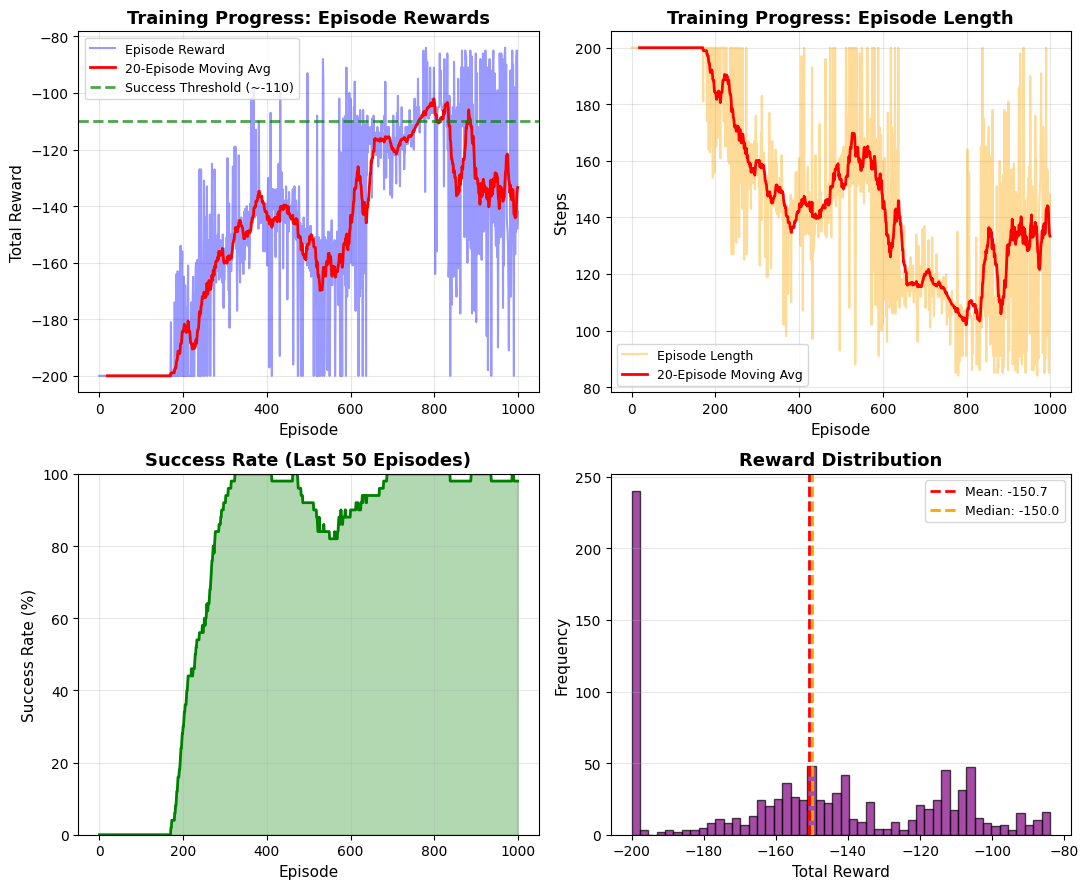


학습 통계:
  최고 보상: -84.00
  최저 보상: -200.00
  평균 보상: -150.75
  최근 100 에피소드 평균: -133.68


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

# 1. Episode Rewards
window = 20
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
axes[0, 0].plot(episode_rewards, alpha=0.4, label='Episode Reward', color='blue')
axes[0, 0].plot(range(window-1, len(episode_rewards)), moving_avg,
                'r-', linewidth=2, label=f'{window}-Episode Moving Avg')
axes[0, 0].axhline(y=-110, color='green', linestyle='--', linewidth=2,
                   label='Success Threshold (~-110)', alpha=0.7)
axes[0, 0].set_xlabel('Episode', fontsize=11)
axes[0, 0].set_ylabel('Total Reward', fontsize=11)
axes[0, 0].set_title('Training Progress: Episode Rewards', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# 2. Episode Lengths
moving_avg_len = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
axes[0, 1].plot(episode_lengths, alpha=0.4, label='Episode Length', color='orange')
axes[0, 1].plot(range(window-1, len(episode_lengths)), moving_avg_len,
                'r-', linewidth=2, label=f'{window}-Episode Moving Avg')
axes[0, 1].set_xlabel('Episode', fontsize=11)
axes[0, 1].set_ylabel('Steps', fontsize=11)
axes[0, 1].set_title('Training Progress: Episode Length', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# 3. Success Rate Over Time
success_window = 50
success_rate = []
for i in range(len(episode_rewards)):
    if i < success_window:
        window_rewards = episode_rewards[:i+1]
    else:
        window_rewards = episode_rewards[i-success_window+1:i+1]
    success_rate.append(sum(1 for r in window_rewards if r > -200) / len(window_rewards) * 100)

axes[1, 0].plot(success_rate, color='green', linewidth=2)
axes[1, 0].fill_between(range(len(success_rate)), success_rate, alpha=0.3, color='green')
axes[1, 0].set_xlabel('Episode', fontsize=11)
axes[1, 0].set_ylabel('Success Rate (%)', fontsize=11)
axes[1, 0].set_title(f'Success Rate (Last {success_window} Episodes)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 100)

# 4. Reward Distribution
axes[1, 1].hist(episode_rewards, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=np.mean(episode_rewards), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {np.mean(episode_rewards):.1f}')
axes[1, 1].axvline(x=np.median(episode_rewards), color='orange', linestyle='--',
                   linewidth=2, label=f'Median: {np.median(episode_rewards):.1f}')
axes[1, 1].set_xlabel('Total Reward', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Reward Distribution', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n학습 통계:")
print(f"  최고 보상: {max(episode_rewards):.2f}")
print(f"  최저 보상: {min(episode_rewards):.2f}")
print(f"  평균 보상: {np.mean(episode_rewards):.2f}")
print(f"  최근 100 에피소드 평균: {np.mean(episode_rewards[-100:]):.2f}")

## 7. SHAP 준비 - 핵심 개념

### SHAP (SHapley Additive exPlanations)란?

**게임 이론의 Shapley Value를 ML에 적용:**
- 여러 플레이어가 협력하여 달성한 성과를 각 플레이어에게 공정하게 분배하는 방법
- ML에서는 각 feature를 "플레이어"로, 예측값을 "성과"로 봄

**SHAP의 핵심 특성:**
1. **Local Accuracy**: 개별 예측에 대한 정확한 설명
2. **Missingness**: 없는 feature의 기여도는 0
3. **Consistency**: feature 기여도가 증가하면 SHAP value도 증가
4. **Additivity**: 전체 예측 = baseline + 각 feature의 SHAP value 합

**IG vs SHAP:**
- IG: gradient 기반, 빠름, 선형 경로
- SHAP: 조합 기반, 느림, 모든 가능한 feature 조합 고려

In [ ]:
# PyTorch 모델을 SHAP에서 사용할 수 있도록 래핑
class ModelWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()

    def __call__(self, x):
        """SHAP가 호출할 수 있는 인터페이스"""
        if isinstance(x, np.ndarray):
            x = torch.FloatTensor(x).to(self.device)

        with torch.no_grad():
            output = self.model(x)

        return output.cpu().numpy()

# 모델 래퍼 생성
wrapped_model = ModelWrapper(policy_net, device)

# 상태 변수 이름
feature_names = ['Position', 'Velocity']

print("SHAP를 위한 모델 래핑 완료!")
print(f"Feature names: {feature_names}")

# 테스트
test_state = np.array([[-0.5, 0.0]])
test_output = wrapped_model(test_state)
print(f"\n테스트 - 입력: {test_state[0]}")
print(f"출력 Q-values: {test_output[0]}")
print(f"선택할 action: {np.argmax(test_output[0])}")

SHAP를 위한 모델 래핑 완료!
Feature names: ['Position', 'Velocity']

테스트 - 입력: [-0.5  0. ]
출력 Q-values: [-57.716675 -59.02915  -58.54238 ]
선택할 action: 0


## 8. 다양한 상태 수집

분석을 위해 다양한 위치와 속도의 상태를 수집합니다.

상태 수집 중...

수집된 상태:
  전체: 2636
  왼쪽 언덕: 1402 (position < -0.5)
  골짜기: 411 (-0.5 <= position < -0.2)
  오른쪽 언덕: 823 (position >= -0.2)


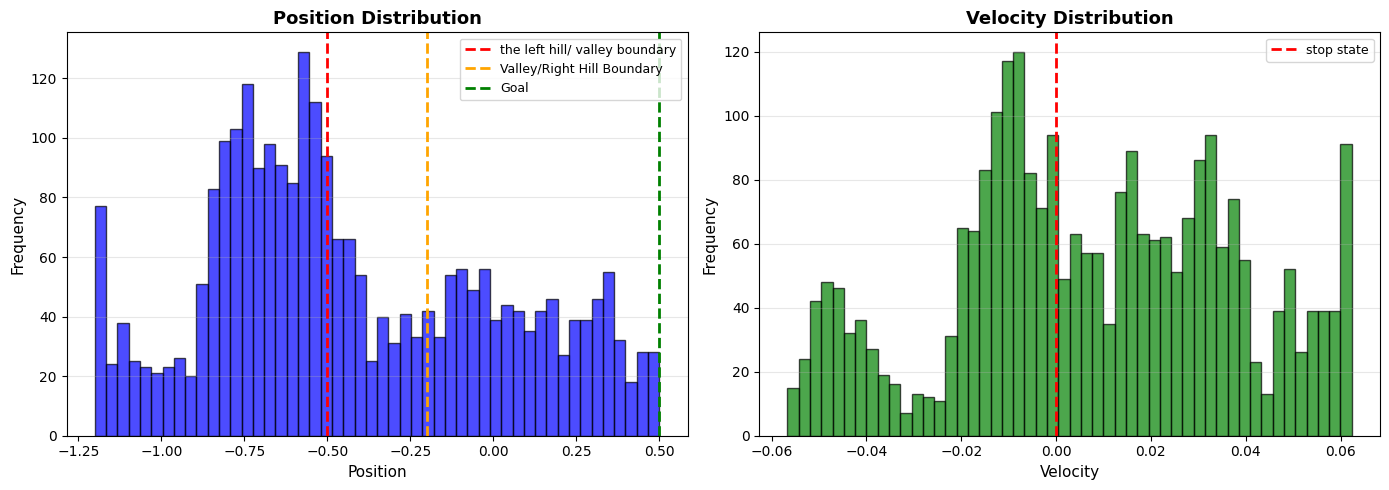

In [ ]:
def collect_diverse_states(num_episodes=20):
    """다양한 상태를 수집하고 분류"""
    all_states = []
    left_hill_states = []   # 왼쪽 언덕 (position < -0.5)
    valley_states = []      # 골짜기 (-0.5 <= position < -0.2)
    right_hill_states = []  # 오른쪽 언덕 (position >= -0.2)

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            # 상태 저장
            all_states.append(state.copy())

            # 위치 기반 분류
            position = state[0]
            if position < -0.5:
                left_hill_states.append(state.copy())
            elif position < -0.2:
                valley_states.append(state.copy())
            else:
                right_hill_states.append(state.copy())

            # Greedy action selection
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                action = policy_net(state_tensor).argmax(1).item()

            state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

    return (np.array(all_states),
            np.array(left_hill_states),
            np.array(valley_states),
            np.array(right_hill_states))

# 상태 수집
print("상태 수집 중...")
all_states, left_hill, valley, right_hill = collect_diverse_states(num_episodes=20)

print(f"\n수집된 상태:")
print(f"  전체: {len(all_states)}")
print(f"  왼쪽 언덕: {len(left_hill)} (position < -0.5)")
print(f"  골짜기: {len(valley)} (-0.5 <= position < -0.2)")
print(f"  오른쪽 언덕: {len(right_hill)} (position >= -0.2)")

# 수집된 상태 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Position 분포
axes[0].hist(all_states[:, 0], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=-0.5, color='red', linestyle='--', linewidth=2, label='the left hill/ valley boundary')
axes[0].axvline(x=-0.2, color='orange', linestyle='--', linewidth=2, label='Valley/Right Hill Boundary')
axes[0].axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Goal')
axes[0].set_xlabel('Position', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Position Distribution', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')

# Velocity 분포
axes[1].hist(all_states[:, 1], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='stop state')
axes[1].set_xlabel('Velocity', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Velocity Distribution', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. SHAP Explainer 생성 및 SHAP Values 계산

**KernelExplainer 선택 이유:**
- Model-agnostic: 어떤 모델이든 적용 가능
- 정확한 Shapley values 근사
- 단점: 계산이 느림 (많은 샘플 필요)

In [ ]:
# Background data: SHAP의 baseline으로 사용
# 다양한 상태를 대표하는 샘플 선택
background_size = 100
background_indices = np.random.choice(len(all_states), size=background_size, replace=False)
background_data = all_states[background_indices]

print(f"Background data 생성: {background_data.shape}")
print(f"  Position range: [{background_data[:, 0].min():.3f}, {background_data[:, 0].max():.3f}]")
print(f"  Velocity range: [{background_data[:, 1].min():.3f}, {background_data[:, 1].max():.3f}]")

# SHAP KernelExplainer 생성
print("\nSHAP Explainer 생성 중...")
explainer = shap.KernelExplainer(wrapped_model, background_data)

print("SHAP Explainer 생성 완료!")
print(f"  Model: DQN with {action_dim} outputs")
print(f"  Background samples: {len(background_data)}")
print(f"  Features: {feature_names}")

Background data 생성: (100, 2)
  Position range: [-1.197, 0.500]
  Velocity range: [-0.050, 0.062]

SHAP Explainer 생성 중...
SHAP Explainer 생성 완료!
  Model: DQN with 3 outputs
  Background samples: 100
  Features: ['Position', 'Velocity']


## 10. 대표 상태들에 대한 SHAP Values 계산

각 영역(왼쪽 언덕, 골짜기, 오른쪽 언덕)에서 샘플을 선택하여 SHAP values를 계산합니다.

In [ ]:
# 각 영역에서 샘플 선택 (SHAP 계산은 느리므로 적은 수 선택)
n_samples_per_region = 30

left_sample_idx = np.random.choice(len(left_hill), size=min(n_samples_per_region, len(left_hill)), replace=False)
valley_sample_idx = np.random.choice(len(valley), size=min(n_samples_per_region, len(valley)), replace=False)
right_sample_idx = np.random.choice(len(right_hill), size=min(n_samples_per_region, len(right_hill)), replace=False)

left_samples = left_hill[left_sample_idx]
valley_samples = valley[valley_sample_idx]
right_samples = right_hill[right_sample_idx]

print("SHAP values 계산 중...")
print("(KernelExplainer는 느립니다. 각 샘플당 수백 번의 모델 호출이 필요합니다)\n")

# SHAP values 계산
print("왼쪽 언덕 샘플 계산 중...")
shap_values_left = explainer.shap_values(left_samples, nsamples=100)

print("골짜기 샘플 계산 중...")
shap_values_valley = explainer.shap_values(valley_samples, nsamples=100)

print("오른쪽 언덕 샘플 계산 중...")
shap_values_right = explainer.shap_values(right_samples, nsamples=100)

print("\n✓ SHAP values 계산 완료!")
print(f"\nSHAP values shape:")
print(f"  Left hill: {len(shap_values_left)} actions × {shap_values_left[0].shape}")
print(f"  Valley: {len(shap_values_valley)} actions × {shap_values_valley[0].shape}")
print(f"  Right hill: {len(shap_values_right)} actions × {shap_values_right[0].shape}")

## 11. 시각화 1: Summary Plot - Feature 중요도 전체 개요

SHAP summary plot은 각 feature의 영향력을 한눈에 보여줍니다.

원본 SHAP values 확인:
  shap_values_left type: <class 'numpy.ndarray'>
  shap_values_left shape: (30, 2, 3)
  numpy 배열 형태. Shape: (30, 2, 3)

샘플 수:
  left_samples: (30, 2)
  valley_samples: (30, 2)
  right_samples: (30, 2)

재구성 후:
  shap_left_by_action[0] shape: (30, 2)
  shap_valley_by_action[0] shape: (30, 2)
  shap_right_by_action[0] shape: (30, 2)

최종 결합 후:
  all_samples shape: (90, 2)
  len(all_shap_values): 3
  all_shap_values[0] shape: (90, 2)
  all_shap_values[1] shape: (90, 2)
  all_shap_values[2] shape: (90, 2)
  Number of features: 2

Action 0 - Summary Plot:
  SHAP shape: (90, 2)
  Samples shape: (90, 2)

Action 1 - Summary Plot:
  SHAP shape: (90, 2)
  Samples shape: (90, 2)

Action 2 - Summary Plot:
  SHAP shape: (90, 2)
  Samples shape: (90, 2)


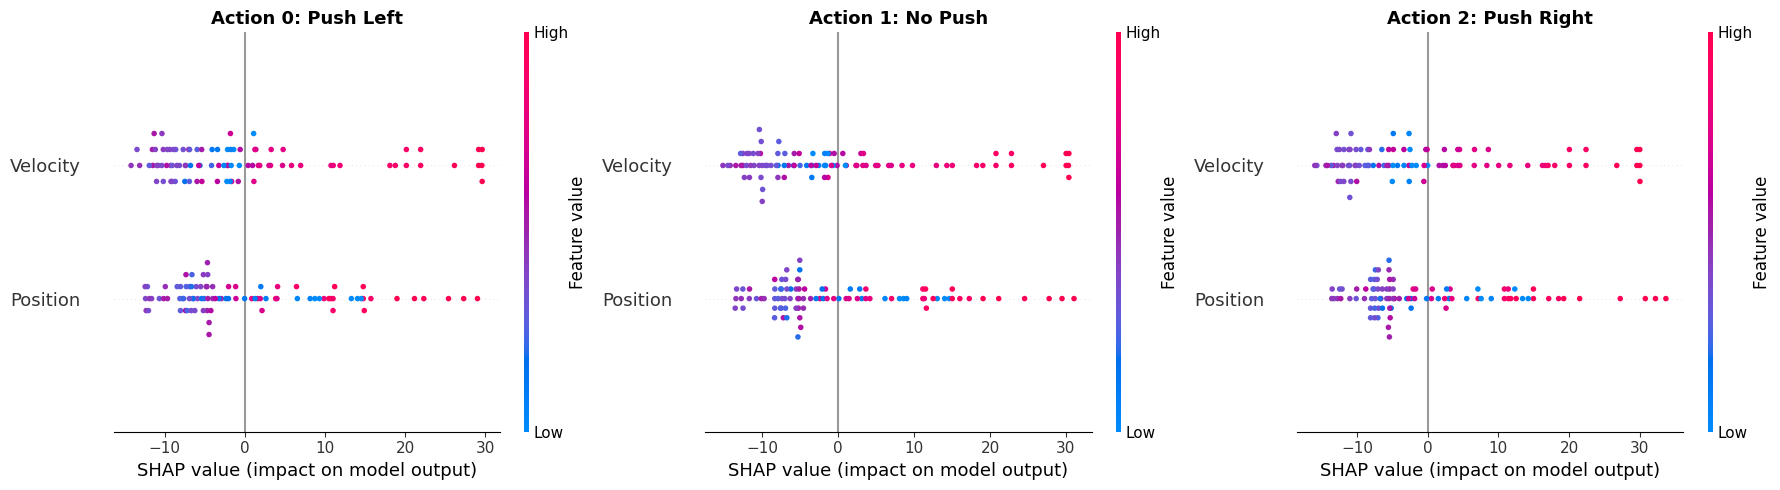


📊 Summary Plot 해석:
  - 각 점은 하나의 샘플
  - Y축: Feature 이름 (중요도 순)
  - X축: SHAP value (양수 = Q-value 증가, 음수 = Q-value 감소)
  - 색상: Feature 값 (빨강 = 높음, 파랑 = 낮음)


In [ ]:
# 원본 SHAP values shape 확인
print("원본 SHAP values 확인:")
print(f"  shap_values_left type: {type(shap_values_left)}")
print(f"  shap_values_left shape: {np.array(shap_values_left).shape}")

# SHAP values 재구성
# KernelExplainer는 (n_samples, n_features, n_actions) 또는 리스트 형태로 반환
# 현재: shap_values_left는 (30, 2, 3) - 30 샘플, 2 features, 3 actions
# 필요: action별로 분리 - [action0:(30,2), action1:(30,2), action2:(30,2)]

if isinstance(shap_values_left, np.ndarray):
    # numpy 배열인 경우
    print(f"  numpy 배열 형태. Shape: {shap_values_left.shape}")

    # (n_samples, n_features, n_actions) -> 리스트로 변환
    # shap_values_left[i]는 (2, 3) - 2 features, 3 actions
    # 이를 action별로 분리

    n_samples_left = len(shap_values_left)
    n_samples_valley = len(shap_values_valley)
    n_samples_right = len(shap_values_right)

    print(f"\n샘플 수:")
    print(f"  left_samples: {left_samples.shape}")
    print(f"  valley_samples: {valley_samples.shape}")
    print(f"  right_samples: {right_samples.shape}")

    # Action별로 SHAP values 재구성
    shap_left_by_action = []
    shap_valley_by_action = []
    shap_right_by_action = []

    for action_idx in range(action_dim):
        # 각 action에 대한 SHAP values 추출 (n_samples, n_features)
        shap_left_by_action.append(
            np.array([shap_values_left[i][:, action_idx] for i in range(n_samples_left)])
        )
        shap_valley_by_action.append(
            np.array([shap_values_valley[i][:, action_idx] for i in range(n_samples_valley)])
        )
        shap_right_by_action.append(
            np.array([shap_values_right[i][:, action_idx] for i in range(n_samples_right)])
        )

    print(f"\n재구성 후:")
    print(f"  shap_left_by_action[0] shape: {shap_left_by_action[0].shape}")
    print(f"  shap_valley_by_action[0] shape: {shap_valley_by_action[0].shape}")
    print(f"  shap_right_by_action[0] shape: {shap_right_by_action[0].shape}")

else:
    # 리스트인 경우 (원래 예상 형태)
    print(f"  리스트 형태. Length: {len(shap_values_left)}")
    shap_left_by_action = shap_values_left
    shap_valley_by_action = shap_values_valley
    shap_right_by_action = shap_values_right

# 모든 샘플 결합
all_samples = np.vstack([left_samples, valley_samples, right_samples])

# SHAP values 결합
all_shap_values = [
    np.vstack([shap_left_by_action[i], shap_valley_by_action[i], shap_right_by_action[i]])
    for i in range(action_dim)
]

# SHAP values 형태 확인
print(f"\n최종 결합 후:")
print(f"  all_samples shape: {all_samples.shape}")
print(f"  len(all_shap_values): {len(all_shap_values)}")
print(f"  all_shap_values[0] shape: {all_shap_values[0].shape}")
print(f"  all_shap_values[1] shape: {all_shap_values[1].shape}")
print(f"  all_shap_values[2] shape: {all_shap_values[2].shape}")
print(f"  Number of features: {state_dim}")

# 각 action별로 summary plot 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

action_names = ['Action 0: Push Left', 'Action 1: No Push', 'Action 2: Push Right']

for action_idx in range(action_dim):
    plt.sca(axes[action_idx])

    shap_vals = all_shap_values[action_idx]

    print(f"\nAction {action_idx} - Summary Plot:")
    print(f"  SHAP shape: {shap_vals.shape}")
    print(f"  Samples shape: {all_samples.shape}")

    # Shape 검증
    assert shap_vals.shape[0] == all_samples.shape[0], \
        f"샘플 수 불일치! SHAP: {shap_vals.shape[0]} vs Samples: {all_samples.shape[0]}"
    assert shap_vals.shape[1] == all_samples.shape[1], \
        f"Feature 수 불일치! SHAP: {shap_vals.shape[1]} vs Samples: {all_samples.shape[1]}"

    shap.summary_plot(
        shap_vals,
        all_samples,
        feature_names=feature_names,
        show=False,
        plot_size=None
    )
    axes[action_idx].set_title(action_names[action_idx], fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Summary Plot 해석:")
print("  - 각 점은 하나의 샘플")
print("  - Y축: Feature 이름 (중요도 순)")
print("  - X축: SHAP value (양수 = Q-value 증가, 음수 = Q-value 감소)")
print("  - 색상: Feature 값 (빨강 = 높음, 파랑 = 낮음)")


## 12. 시각화 2: Bar Plot - 위치별 Feature 중요도 비교

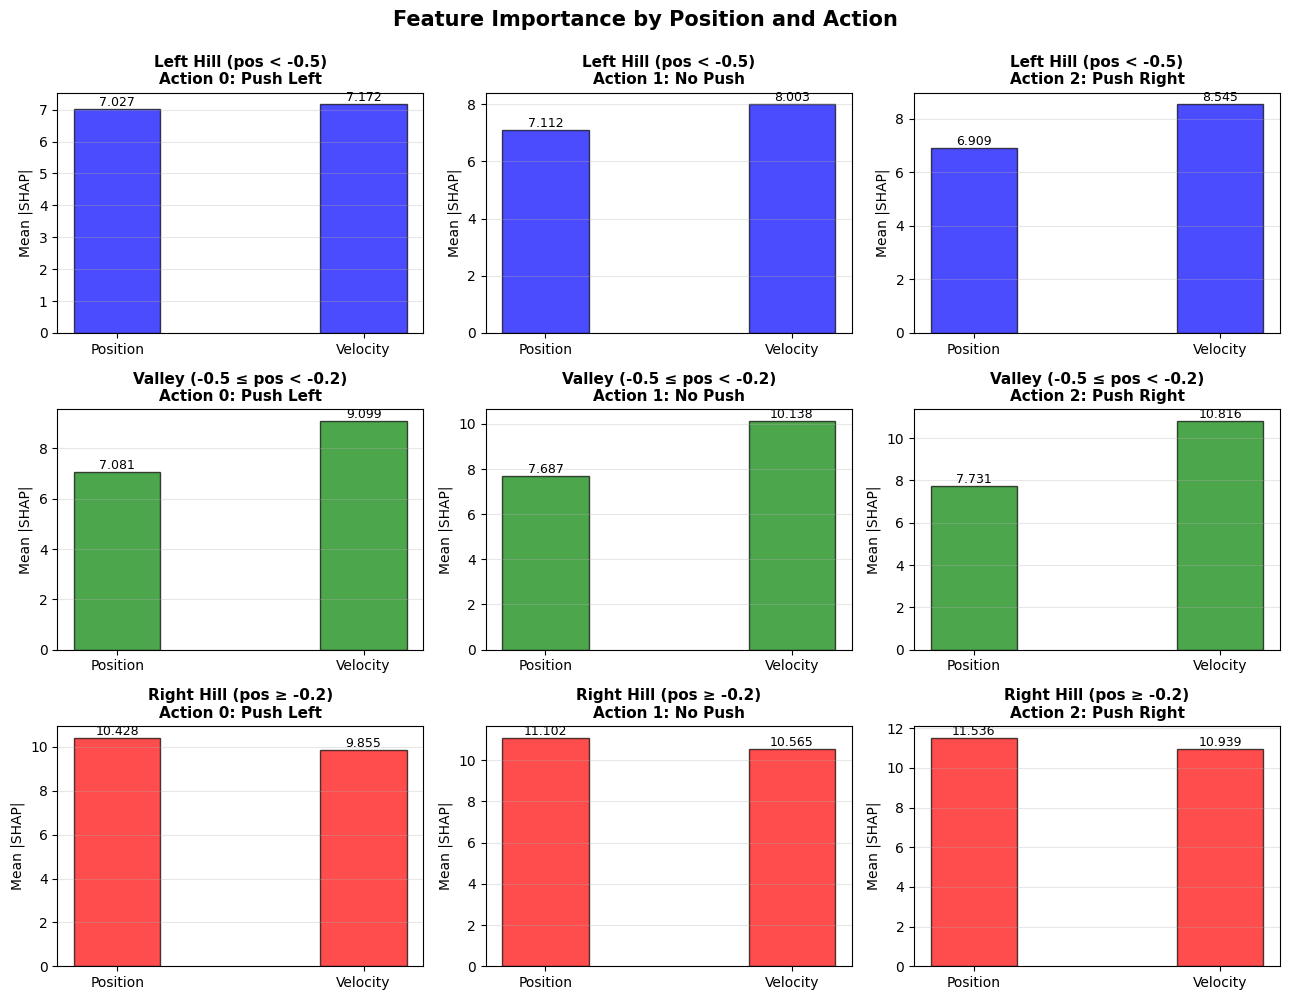


📊 평균 절대 SHAP Values:

Left Hill (pos < -0.5):
  Action 0: Push Left:
    Position: 7.0273
    Velocity: 7.1723
  Action 1: No Push:
    Position: 7.1122
    Velocity: 8.0026
  Action 2: Push Right:
    Position: 6.9092
    Velocity: 8.5450

Valley (-0.5 ≤ pos < -0.2):
  Action 0: Push Left:
    Position: 7.0810
    Velocity: 9.0995
  Action 1: No Push:
    Position: 7.6872
    Velocity: 10.1383
  Action 2: Push Right:
    Position: 7.7311
    Velocity: 10.8155

Right Hill (pos ≥ -0.2):
  Action 0: Push Left:
    Position: 10.4280
    Velocity: 9.8549
  Action 1: No Push:
    Position: 11.1016
    Velocity: 10.5652
  Action 2: Push Right:
    Position: 11.5363
    Velocity: 10.9387


In [ ]:
# 각 영역, 각 action별 평균 SHAP value 계산
def compute_mean_abs_shap(shap_values_array):
    """평균 절대 SHAP value 계산

    Args:
        shap_values_array: numpy 배열 (n_samples, n_features, n_actions)
                          또는 리스트 [action0_shap, action1_shap, action2_shap]
    """
    # numpy 배열인 경우 action별로 분리
    if isinstance(shap_values_array, np.ndarray):
        n_samples = len(shap_values_array)
        shap_by_action = []
        for action_idx in range(action_dim):
            shap_by_action.append(
                np.array([shap_values_array[i][:, action_idx] for i in range(n_samples)])
            )
    else:
        # 이미 리스트 형태
        shap_by_action = shap_values_array

    # 평균 절대값 계산
    return np.array([[np.mean(np.abs(shap_by_action[action][:, feature]))
                      for feature in range(state_dim)]
                     for action in range(action_dim)])

mean_shap_left = compute_mean_abs_shap(shap_values_left)
mean_shap_valley = compute_mean_abs_shap(shap_values_valley)
mean_shap_right = compute_mean_abs_shap(shap_values_right)

# 시각화
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
x = np.arange(len(feature_names))
width = 0.35

regions = [
    ('Left Hill (pos < -0.5)', mean_shap_left, 'blue'),
    ('Valley (-0.5 ≤ pos < -0.2)', mean_shap_valley, 'green'),
    ('Right Hill (pos ≥ -0.2)', mean_shap_right, 'red')
]

for row, (region_name, mean_shap, color) in enumerate(regions):
    for col, action_idx in enumerate(range(action_dim)):
        ax = axes[row, col]

        bars = ax.bar(x, mean_shap[action_idx], width,
                     color=color, alpha=0.7, edgecolor='black')

        # 값 표시
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)

        ax.set_ylabel('Mean |SHAP|', fontsize=10)
        ax.set_title(f'{region_name}\n{action_names[action_idx]}',
                    fontsize=11, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(feature_names, fontsize=10)
        ax.grid(axis='y', alpha=0.3)

plt.suptitle('Feature Importance by Position and Action',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# 통계 출력
print("\n📊 평균 절대 SHAP Values:")
for region_name, mean_shap, _ in regions:
    print(f"\n{region_name}:")
    for action_idx in range(action_dim):
        print(f"  {action_names[action_idx]}:")
        for feat_idx, feat_name in enumerate(feature_names):
            print(f"    {feat_name}: {mean_shap[action_idx, feat_idx]:.4f}")


## 13. 시각화 3: Force Plot - 개별 의사결정 상세 분석

특정 상태에서 에이전트의 의사결정 과정을 상세히 분석합니다.

In [ ]:
# 흥미로운 상태 선택
# 1. 왼쪽 언덕에서 오른쪽으로 빠르게 이동 중
# 2. 골짜기 중앙에서 거의 정지
# 3. 오른쪽 언덕에서 목표 근처

interesting_states = []
interesting_descriptions = []

# 1. 왼쪽 언덕, 오른쪽으로 빠른 속도
idx = np.argmax(left_samples[:, 1])  # 가장 큰 양의 velocity
interesting_states.append(left_samples[idx])
interesting_descriptions.append(f"Left Hill, Fast Right\npos={left_samples[idx][0]:.3f}, vel={left_samples[idx][1]:.3f}")

# 2. 골짜기, 낮은 속도
idx = np.argmin(np.abs(valley_samples[:, 1]))  # velocity가 0에 가장 가까운
interesting_states.append(valley_samples[idx])
interesting_descriptions.append(f"Valley Center, Almost Still\npos={valley_samples[idx][0]:.3f}, vel={valley_samples[idx][1]:.3f}")

# 3. 오른쪽 언덕, 목표 근처
idx = np.argmax(right_samples[:, 0])  # 가장 오른쪽 position
interesting_states.append(right_samples[idx])
interesting_descriptions.append(f"Right Hill, Near Goal\npos={right_samples[idx][0]:.3f}, vel={right_samples[idx][1]:.3f}")

# 각 상태에 대한 SHAP values 계산
print("흥미로운 상태들에 대한 SHAP values 계산 중...")
interesting_shap_raw = explainer.shap_values(np.array(interesting_states), nsamples=200)

# SHAP values 재구성 (Section 11과 동일한 방식)
print(f"\n원본 interesting_shap shape: {np.array(interesting_shap_raw).shape}")

if isinstance(interesting_shap_raw, np.ndarray):
    # numpy 배열인 경우: (3, 2, 3) - 3 샘플, 2 features, 3 actions
    # Action별로 분리: [action0:(3,2), action1:(3,2), action2:(3,2)]
    n_interesting = len(interesting_shap_raw)

    interesting_shap = []
    for action_idx in range(action_dim):
        # 각 action에 대한 SHAP values 추출 (n_samples, n_features)
        interesting_shap.append(
            np.array([interesting_shap_raw[i][:, action_idx] for i in range(n_interesting)])
        )

    print(f"재구성 후 interesting_shap[0] shape: {interesting_shap[0].shape}")
else:
    # 이미 리스트 형태인 경우
    interesting_shap = interesting_shap_raw

# 각 상태, 각 action에 대한 Q-values와 선택된 action 확인
print("\n🎯 선택된 흥미로운 상태들:\n")
for i, (state, desc) in enumerate(zip(interesting_states, interesting_descriptions)):
    q_values = wrapped_model(state.reshape(1, -1))[0]
    selected_action = np.argmax(q_values)

    print(f"{i+1}. {desc}")
    print(f"   Q-values: {q_values}")
    print(f"   Selected action: {selected_action} ({action_names[selected_action]})\n")

# Force plot 시각화 함수 - 개선된 버전
def plot_force_custom(state_idx, action_idx, state, shap_vals, base_value):
    """커스텀 force plot - 개선된 레이아웃"""
    fig, ax = plt.subplots(figsize=(16, 4))

    # SHAP values와 feature values 추출
    shap_array = shap_vals[action_idx][state_idx]

    # Feature 정렬 (절대값 기준 내림차순)
    feature_order = np.argsort(np.abs(shap_array))[::-1]

    # Base value부터 시작
    x_pos = base_value
    bar_data = []

    # 각 feature의 기여도 수집
    for feat_idx in feature_order:
        shap_val = shap_array[feat_idx]
        feat_val = state[feat_idx]

        if abs(shap_val) > 0.001:  # 작은 값 무시
            bar_data.append({
                'feat_idx': feat_idx,
                'shap_val': shap_val,
                'feat_val': feat_val,
                'start': x_pos,
                'end': x_pos + shap_val
            })
            x_pos += shap_val

    # 막대 그리기
    for data in bar_data:
        color = 'red' if data['shap_val'] > 0 else 'blue'
        width = abs(data['shap_val'])

        # 막대
        ax.barh(0, width, left=data['start'] if data['shap_val'] > 0 else data['end'],
               height=0.6, color=color, alpha=0.7, edgecolor='black', linewidth=2)

        # 라벨 (막대 위에)
        center_x = (data['start'] + data['end']) / 2
        label_text = f"{feature_names[data['feat_idx']]}\n{data['feat_val']:.3f}\n({data['shap_val']:+.3f})"
        ax.text(center_x, 1.2, label_text,
               ha='center', va='bottom', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=color, linewidth=2))

    # 최종 예측값
    final_value = base_value + np.sum(shap_array)

    # Base value와 최종 예측값 선
    ax.axvline(x=base_value, color='gray', linestyle='--', linewidth=3,
              label=f'Base Value = {base_value:.3f}', zorder=10)
    ax.axvline(x=final_value, color='green', linestyle='--', linewidth=3,
              label=f'Prediction = {final_value:.3f}', zorder=10)

    # 화살표로 흐름 표시
    ax.annotate('', xy=(final_value, 0), xytext=(base_value, 0),
               arrowprops=dict(arrowstyle='->', lw=2, color='black', alpha=0.5))

    # 축 설정
    x_min = min(base_value, final_value) - 2
    x_max = max(base_value, final_value) + 2
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-1.5, 3)
    ax.set_yticks([])
    ax.set_xlabel('Q-value', fontsize=12, fontweight='bold')
    ax.set_title(f'{action_names[action_idx]} - Feature Contributions',
                fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # 배경 색상
    ax.set_facecolor('#f8f9fa')

    return fig

# 각 흥미로운 상태에 대해 force plot 생성
for state_idx, desc in enumerate(interesting_descriptions):
    print(f"\n{'='*80}")
    print(f"State {state_idx+1}: {desc}")
    print(f"{'='*80}")

    # 해당 상태의 Q-values
    q_values = wrapped_model(interesting_states[state_idx].reshape(1, -1))[0]
    selected_action = np.argmax(q_values)

    # Base value (background data의 평균 예측)
    base_values = explainer.expected_value

    print(f"\nQ-values: {q_values}")
    print(f"Selected action: {selected_action} ({action_names[selected_action]})")
    print(f"Base value for selected action: {base_values[selected_action]:.3f}")

    # 선택된 action에 대한 force plot
    fig = plot_force_custom(
        state_idx, selected_action,
        interesting_states[state_idx],
        interesting_shap,
        base_values[selected_action]
    )
    plt.tight_layout()
    plt.show()

    # SHAP values 상세 정보
    print(f"\nSHAP Value Breakdown:")
    shap_array = interesting_shap[selected_action][state_idx]
    for feat_idx in range(state_dim):
        feat_val = interesting_states[state_idx][feat_idx]
        shap_val = shap_array[feat_idx]
        print(f"  {feature_names[feat_idx]:10s}: value={feat_val:+.4f}, SHAP={shap_val:+.4f}")
    print(f"  {'Total':10s}: Base={base_values[selected_action]:.4f} + Sum(SHAP)={np.sum(shap_array):.4f} = {base_values[selected_action] + np.sum(shap_array):.4f}")

print("\n\n" + "="*80)
print("📊 Force Plot 해석")
print("="*80)
print("  - Base Value (회색 점선): Background 데이터의 평균 Q-value")
print("  - 빨간색 막대: Q-value를 증가시키는 feature (양의 기여)")
print("  - 파란색 막대: Q-value를 감소시키는 feature (음의 기여)")
print("  - Prediction (녹색 점선): 최종 Q-value = Base + 모든 SHAP values 합")
print("  - 화살표: Base에서 최종 예측까지의 흐름")
print("  - 각 막대 위 라벨: Feature 이름, 실제 값, SHAP value")


## 14. 시각화 4: Waterfall Plot - Feature 기여도 폭포수 차트

Waterfall Plot 예시:
State: Valley Center, Almost Still
pos=-0.485, vel=-0.001
  Position: -0.4847
  Velocity: -0.0013

Q-values for this state:
  Action 0: Push Left: -57.0140 ← Selected
  Action 1: No Push: -58.3782
  Action 2: Push Right: -58.0288

SHAP values shape: [(2,), (2,), (2,)]


Action 0: Push Left

Base Value (E[f(x)]): -39.7177
SHAP Values:
  Position  : -6.9358
  Velocity  : -10.3606

Sum of SHAP values: -17.2964
Final Q-value: -39.7177 + -17.2964 = -57.0140
(Model prediction: -57.0140)


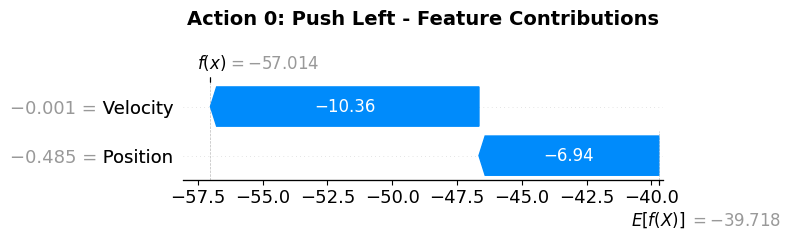



Action 1: No Push

Base Value (E[f(x)]): -39.1501
SHAP Values:
  Position  : -7.5298
  Velocity  : -11.6983

Sum of SHAP values: -19.2281
Final Q-value: -39.1501 + -19.2281 = -58.3782
(Model prediction: -58.3782)


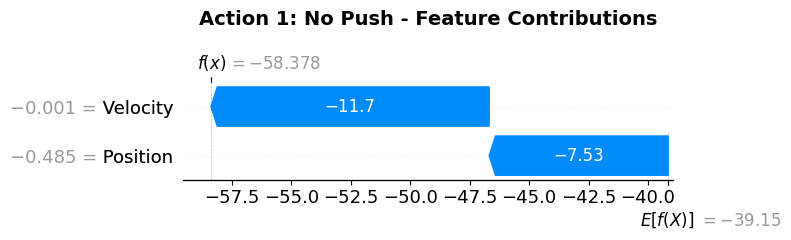



Action 2: Push Right

Base Value (E[f(x)]): -38.3364
SHAP Values:
  Position  : -7.5711
  Velocity  : -12.1213

Sum of SHAP values: -19.6924
Final Q-value: -38.3364 + -19.6924 = -58.0288
(Model prediction: -58.0288)


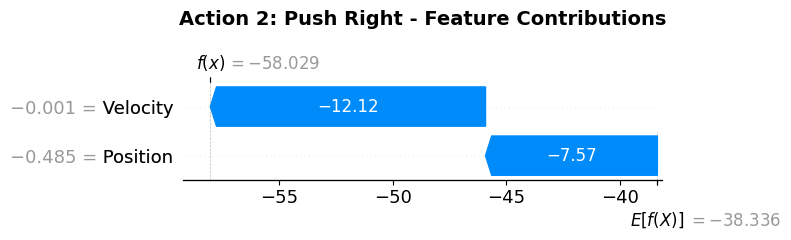



📊 Waterfall Plot 해석 가이드
  - E[f(x)]: Expected value (baseline) - Background 데이터의 평균 Q-value
  - 각 막대: Feature의 기여도
  - 빨간색 막대 (→): 양의 기여 (Q-value 증가)
  - 파란색 막대 (←): 음의 기여 (Q-value 감소)
  - f(x): 최종 예측값 = E[f(x)] + 모든 SHAP values의 합

💡 폭포수(Waterfall) 형태로 각 feature가 순차적으로 예측값에 기여하는 과정을 시각화.
   각 막대의 시작점은 이전까지의 누적 기여도이고, 막대 길이가 해당 feature의 기여도.


In [ ]:
# 대표 상태 하나 선택 (골짜기 중앙)
example_idx = 1  # 골짜기 중앙
example_state = interesting_states[example_idx]

# interesting_shap은 이미 action별로 분리되어 있음: [action0:(3,2), action1:(3,2), action2:(3,2)]
# example_idx=1에 해당하는 SHAP values 추출
example_shap = [interesting_shap[action_idx][example_idx] for action_idx in range(action_dim)]

print(f"Waterfall Plot 예시:")
print(f"State: {interesting_descriptions[example_idx]}")
print(f"  Position: {example_state[0]:.4f}")
print(f"  Velocity: {example_state[1]:.4f}\n")

# Q-values 확인
q_values = wrapped_model(example_state.reshape(1, -1))[0]
selected_action = np.argmax(q_values)
print(f"Q-values for this state:")
for a in range(action_dim):
    marker = " ← Selected" if a == selected_action else ""
    print(f"  {action_names[a]}: {q_values[a]:.4f}{marker}")

print(f"\nSHAP values shape: {[example_shap[a].shape for a in range(action_dim)]}")
print("="*80 + "\n")

# 각 action별로 개별 waterfall plot 생성 (subplot 대신 개별 figure 사용)
for action_idx in range(action_dim):
    print(f"\n{'='*80}")
    print(f"{action_names[action_idx]}")
    print(f"{'='*80}")

    # SHAP Explanation 객체 생성
    shap_explanation = shap.Explanation(
        values=example_shap[action_idx],  # (2,) shape
        base_values=explainer.expected_value[action_idx],
        data=example_state,
        feature_names=feature_names
    )

    # 상세 정보 출력
    print(f"\nBase Value (E[f(x)]): {explainer.expected_value[action_idx]:.4f}")
    print(f"SHAP Values:")
    for feat_idx in range(state_dim):
        print(f"  {feature_names[feat_idx]:10s}: {example_shap[action_idx][feat_idx]:+.4f}")

    total_shap = np.sum(example_shap[action_idx])
    final_value = explainer.expected_value[action_idx] + total_shap
    print(f"\nSum of SHAP values: {total_shap:+.4f}")
    print(f"Final Q-value: {explainer.expected_value[action_idx]:.4f} + {total_shap:+.4f} = {final_value:.4f}")
    print(f"(Model prediction: {q_values[action_idx]:.4f})")

    # Waterfall plot (개별 figure)
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap_explanation, show=False)
    plt.title(f'{action_names[action_idx]} - Feature Contributions',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    print()

print("\n" + "="*80)
print("📊 Waterfall Plot 해석 가이드")
print("="*80)
print("  - E[f(x)]: Expected value (baseline) - Background 데이터의 평균 Q-value")
print("  - 각 막대: Feature의 기여도")
print("  - 빨간색 막대 (→): 양의 기여 (Q-value 증가)")
print("  - 파란색 막대 (←): 음의 기여 (Q-value 감소)")
print("  - f(x): 최종 예측값 = E[f(x)] + 모든 SHAP values의 합")
print("\n💡 폭포수(Waterfall) 형태로 각 feature가 순차적으로 예측값에 기여하는 과정을 시각화.")
print("   각 막대의 시작점은 이전까지의 누적 기여도이고, 막대 길이가 해당 feature의 기여도.")

## 15. 시각화 5: Dependence Plot - Feature 간 상호작용


분석 대상: Action 2: Push Right

Position 분석:
  SHAP 범위: [-13.5694, 33.7050]
  평균 |SHAP|: 8.7255
  Feature 범위: [-1.2000, 0.4839]

Velocity 분석:
  SHAP 범위: [-15.9706, 30.0389]
  평균 |SHAP|: 10.0997
  Feature 범위: [-0.0517, 0.0624]


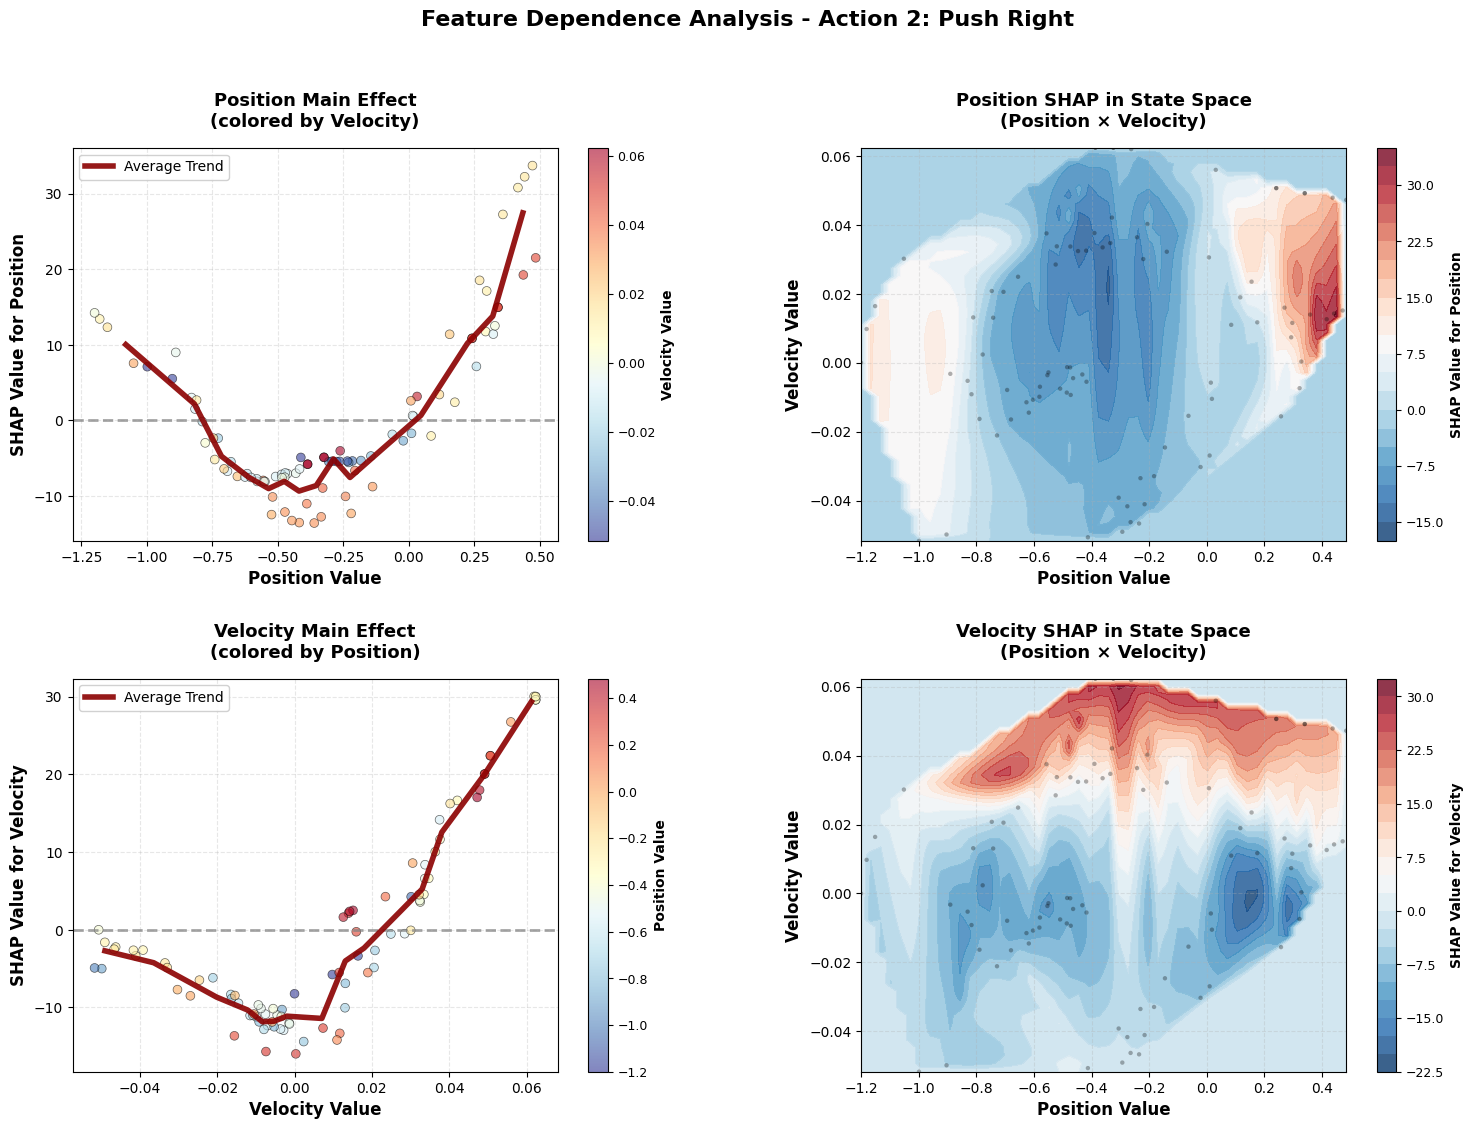


📊 Dependence Plot 해석

왼쪽 열 (Main Effect Plots):
  - X축: Feature 값
  - Y축: 해당 feature의 SHAP value
  - 색상: 다른 feature의 값 (상호작용을 나타냄)
  - 빨간 굵은 선: 평균 경향선
  - 회색 점선: SHAP = 0 기준선
  → Feature 값이 변할 때 SHAP value가 어떻게 변하는지 보여줌

오른쪽 열 (Interaction Heatmaps):
  - X축 & Y축: Position × Velocity 상태 공간
  - 색상: 해당 위치에서의 SHAP value
  - 빨간색: 양의 SHAP (Q-value 증가)
  - 파란색: 음의 SHAP (Q-value 감소)
  - 검은 점: 실제 수집된 데이터 포인트
  → 상태 공간의 어느 영역에서 feature가 중요한지 한눈에 파악

 이 시각화로 알 수 있는 것:
  1. 각 feature의 비선형 효과 (Main Effect)
  2. Feature 간 상호작용 패턴 (색상 분포)
  3. 상태 공간에서 feature 중요도의 공간적 분포 (Heatmap)


In [ ]:
# Dependence plot: Feature 값과 SHAP value의 관계
# 2×2 레이아웃: 각 feature의 main effect + interaction 시각화

# Action 2 (Push Right) - 가장 중요한 action
action_idx = 2

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.3)

print(f"\n분석 대상: {action_names[action_idx]}")
print("="*80)

# 각 feature에 대해 2개의 plot 생성
for feat_idx, feat_name in enumerate(feature_names):
    # 다른 feature (interaction)
    other_feat_idx = 1 - feat_idx
    other_feat_name = feature_names[other_feat_idx]

    # 현재 feature의 통계
    shap_vals_feat = all_shap_values[action_idx][:, feat_idx]
    feat_vals = all_samples[:, feat_idx]

    print(f"\n{feat_name} 분석:")
    print(f"  SHAP 범위: [{np.min(shap_vals_feat):.4f}, {np.max(shap_vals_feat):.4f}]")
    print(f"  평균 |SHAP|: {np.mean(np.abs(shap_vals_feat)):.4f}")
    print(f"  Feature 범위: [{np.min(feat_vals):.4f}, {np.max(feat_vals):.4f}]")

    # Row 결정
    row = feat_idx

    # 1. Main Effect Plot (왼쪽): 해당 feature의 SHAP value
    ax_main = fig.add_subplot(gs[row, 0])

    # 다른 feature 값으로 색상 구분
    scatter_main = ax_main.scatter(
        feat_vals,
        shap_vals_feat,
        c=all_samples[:, other_feat_idx],
        cmap='RdYlBu_r',
        alpha=0.6,
        s=40,
        edgecolors='black',
        linewidth=0.5
    )

    # 평균 경향선 (굵고 명확하게)
    sorted_idx = np.argsort(feat_vals)
    window_size = max(len(all_samples) // 15, 1)
    moving_avg_x = []
    moving_avg_y = []

    for i in range(0, len(sorted_idx), window_size):
        idx_window = sorted_idx[i:i+window_size]
        if len(idx_window) > 0:
            moving_avg_x.append(np.mean(feat_vals[idx_window]))
            moving_avg_y.append(np.mean(shap_vals_feat[idx_window]))

    ax_main.plot(moving_avg_x, moving_avg_y,
                color='darkred', linewidth=4, alpha=0.9,
                label='Average Trend', zorder=10)

    # Zero line
    ax_main.axhline(y=0, color='gray', linestyle='--', linewidth=2, alpha=0.7)

    ax_main.set_xlabel(f'{feat_name} Value', fontsize=12, fontweight='bold')
    ax_main.set_ylabel(f'SHAP Value for {feat_name}', fontsize=12, fontweight='bold')
    ax_main.set_title(f'{feat_name} Main Effect\n(colored by {other_feat_name})',
                     fontsize=13, fontweight='bold', pad=15)
    ax_main.grid(True, alpha=0.3, linestyle='--')
    ax_main.legend(loc='best', fontsize=10, framealpha=0.9)

    # Colorbar
    cbar_main = plt.colorbar(scatter_main, ax=ax_main)
    cbar_main.set_label(f'{other_feat_name} Value', fontsize=10, fontweight='bold')
    cbar_main.ax.tick_params(labelsize=9)

    # 2. Interaction Heatmap (오른쪽): 2D 공간에서 SHAP value 분포
    ax_heat = fig.add_subplot(gs[row, 1])

    # 그리드 생성
    if feat_idx == 0:  # Position
        x_range = np.linspace(feat_vals.min(), feat_vals.max(), 50)
        y_range = np.linspace(all_samples[:, 1].min(), all_samples[:, 1].max(), 50)
    else:  # Velocity
        x_range = np.linspace(all_samples[:, 0].min(), all_samples[:, 0].max(), 50)
        y_range = np.linspace(feat_vals.min(), feat_vals.max(), 50)

    x_grid, y_grid = np.meshgrid(x_range, y_range)

    # 각 그리드 포인트에서 SHAP value 보간
    from scipy.interpolate import griddata

    if feat_idx == 0:  # Position
        points = np.column_stack([feat_vals, all_samples[:, 1]])
    else:  # Velocity
        points = np.column_stack([all_samples[:, 0], feat_vals])

    grid_shap = griddata(points, shap_vals_feat,
                        (x_grid, y_grid), method='cubic', fill_value=0)

    # Heatmap
    im = ax_heat.contourf(x_grid, y_grid, grid_shap,
                         levels=20, cmap='RdBu_r', alpha=0.8)

    # 실제 데이터 포인트 scatter (작게)
    if feat_idx == 0:
        ax_heat.scatter(feat_vals, all_samples[:, 1],
                       c='black', s=10, alpha=0.3, edgecolors='none')
    else:
        ax_heat.scatter(all_samples[:, 0], feat_vals,
                       c='black', s=10, alpha=0.3, edgecolors='none')

    # 축 레이블
    if feat_idx == 0:  # Position
        ax_heat.set_xlabel('Position Value', fontsize=12, fontweight='bold')
        ax_heat.set_ylabel('Velocity Value', fontsize=12, fontweight='bold')
        ax_heat.set_title('Position SHAP in State Space\n(Position × Velocity)',
                         fontsize=13, fontweight='bold', pad=15)
    else:  # Velocity
        ax_heat.set_xlabel('Position Value', fontsize=12, fontweight='bold')
        ax_heat.set_ylabel('Velocity Value', fontsize=12, fontweight='bold')
        ax_heat.set_title('Velocity SHAP in State Space\n(Position × Velocity)',
                         fontsize=13, fontweight='bold', pad=15)

    ax_heat.grid(True, alpha=0.3, linestyle='--')

    # Colorbar
    cbar_heat = plt.colorbar(im, ax=ax_heat)
    cbar_heat.set_label(f'SHAP Value for {feat_name}', fontsize=10, fontweight='bold')
    cbar_heat.ax.tick_params(labelsize=9)

plt.suptitle(f'Feature Dependence Analysis - {action_names[action_idx]}',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n" + "="*80)
print("📊 Dependence Plot 해석")
print("="*80)
print("\n왼쪽 열 (Main Effect Plots):")
print("  - X축: Feature 값")
print("  - Y축: 해당 feature의 SHAP value")
print("  - 색상: 다른 feature의 값 (상호작용을 나타냄)")
print("  - 빨간 굵은 선: 평균 경향선")
print("  - 회색 점선: SHAP = 0 기준선")
print("  → Feature 값이 변할 때 SHAP value가 어떻게 변하는지 보여줌")

print("\n오른쪽 열 (Interaction Heatmaps):")
print("  - X축 & Y축: Position × Velocity 상태 공간")
print("  - 색상: 해당 위치에서의 SHAP value")
print("  - 빨간색: 양의 SHAP (Q-value 증가)")
print("  - 파란색: 음의 SHAP (Q-value 감소)")
print("  - 검은 점: 실제 수집된 데이터 포인트")
print("  → 상태 공간의 어느 영역에서 feature가 중요한지 한눈에 파악")

print("\n 이 시각화로 알 수 있는 것:")
print("  1. 각 feature의 비선형 효과 (Main Effect)")
print("  2. Feature 간 상호작용 패턴 (색상 분포)")
print("  3. 상태 공간에서 feature 중요도의 공간적 분포 (Heatmap)")

## 16. 시각화 6: Decision Boundary - 위치-속도 공간에서의 Action 선택

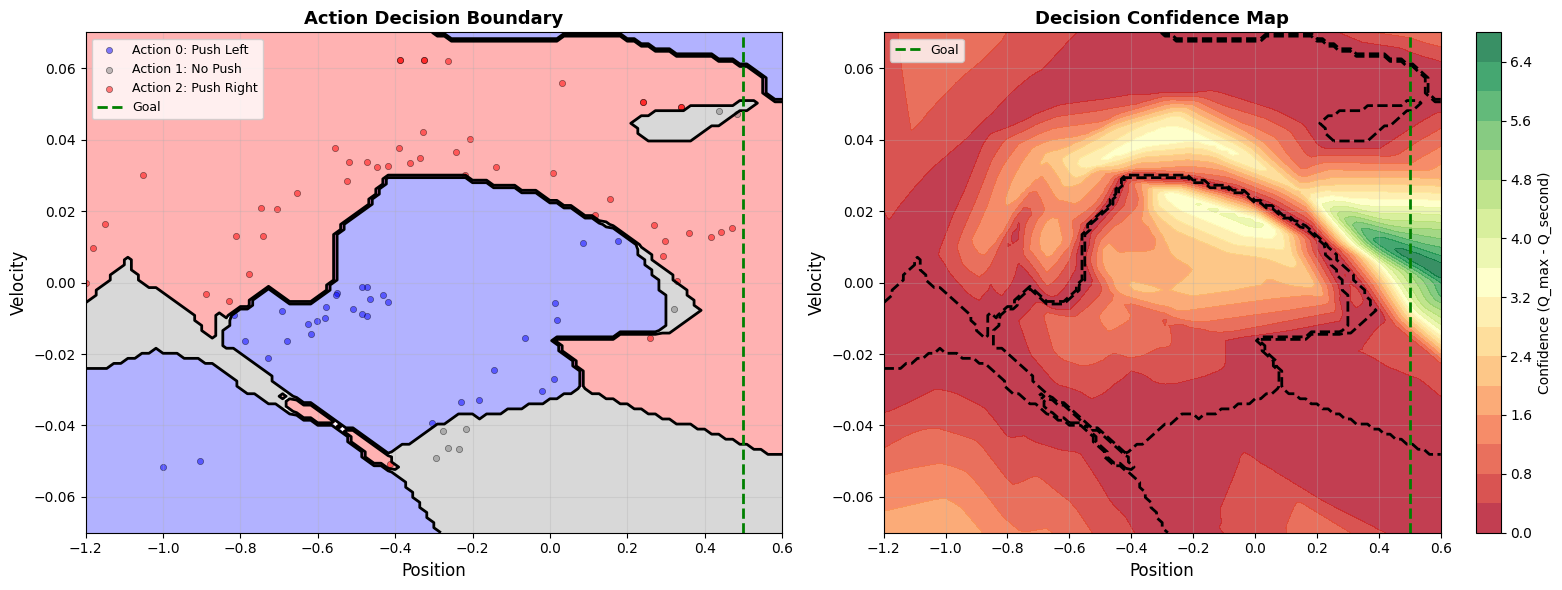


📊 Decision Boundary 해석:
  왼쪽 그림: 각 위치-속도 조합에서 선택되는 action
    - 파란색: Push Left (왼쪽 언덕으로)
    - 회색: No Push (관성)
    - 빨간색: Push Right (오른쪽 언덕으로)
  오른쪽 그림: 의사결정 확신도
    - 녹색: 높은 확신 (Q-value 차이 큼)
    - 노란색/빨간색: 낮은 확신 (여러 action이 비슷한 Q-value)


In [ ]:
# Position-Velocity 공간에서 decision boundary 그리기
pos_range = np.linspace(-1.2, 0.6, 100)
vel_range = np.linspace(-0.07, 0.07, 100)
pos_grid, vel_grid = np.meshgrid(pos_range, vel_range)

# 모든 grid 포인트에 대한 action 예측
grid_states = np.column_stack([pos_grid.ravel(), vel_grid.ravel()])
q_values_grid = wrapped_model(grid_states)
actions_grid = np.argmax(q_values_grid, axis=1).reshape(pos_grid.shape)

# Q-value 차이 계산 (확신도)
max_q = np.max(q_values_grid, axis=1)
second_max_q = np.partition(q_values_grid, -2, axis=1)[:, -2]
confidence = (max_q - second_max_q).reshape(pos_grid.shape)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Action Decision Boundary
action_colors = ['blue', 'gray', 'red']
ax = axes[0]

# Contourf for actions
for action in range(action_dim):
    mask = (actions_grid == action)
    ax.contourf(pos_grid, vel_grid, mask.astype(float),
               levels=[0.5, 1.5], colors=[action_colors[action]], alpha=0.3)

# Contour lines for boundaries
ax.contour(pos_grid, vel_grid, actions_grid,
          levels=[0.5, 1.5], colors='black', linewidths=2)

# 실제 수집된 상태들 scatter
for action in range(action_dim):
    mask = np.array([np.argmax(wrapped_model(s.reshape(1, -1))[0]) == action
                     for s in all_samples])
    ax.scatter(all_samples[mask, 0], all_samples[mask, 1],
              c=action_colors[action], s=20, alpha=0.5,
              label=action_names[action], edgecolors='black', linewidth=0.5)

# 목표 지점 표시
ax.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Goal')

ax.set_xlabel('Position', fontsize=12)
ax.set_ylabel('Velocity', fontsize=12)
ax.set_title('Action Decision Boundary', fontsize=13, fontweight='bold')
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.3)

# 2. Confidence Map
ax = axes[1]
contourf = ax.contourf(pos_grid, vel_grid, confidence,
                       levels=20, cmap='RdYlGn', alpha=0.8)
ax.contour(pos_grid, vel_grid, actions_grid,
          levels=[0.5, 1.5], colors='black', linewidths=2, linestyles='--')

# Colorbar
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label('Confidence (Q_max - Q_second)', fontsize=10)

# 목표 지점
ax.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Goal')

ax.set_xlabel('Position', fontsize=12)
ax.set_ylabel('Velocity', fontsize=12)
ax.set_title('Decision Confidence Map', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Decision Boundary 해석:")
print("  왼쪽 그림: 각 위치-속도 조합에서 선택되는 action")
print("    - 파란색: Push Left (왼쪽 언덕으로)")
print("    - 회색: No Push (관성)")
print("    - 빨간색: Push Right (오른쪽 언덕으로)")
print("  오른쪽 그림: 의사결정 확신도")
print("    - 녹색: 높은 확신 (Q-value 차이 큼)")
print("    - 노란색/빨간색: 낮은 확신 (여러 action이 비슷한 Q-value)")

## 17. 종합 분석 및 결론

MountainCar-SHAP 실험 종합 분석

📊 실험 요약:
  - 학습 에피소드: 1000
  - 최종 평균 보상: -133.68
  - 성공률 (최근 100 에피소드): 98.0%
  - 분석한 상태 수: 90

🔍 SHAP 분석 주요 발견사항:

1. 전체 Feature 중요도 (평균 절대 SHAP value):
   2. Velocity: 9.4591
   1. Position: 8.5127

2. Action별 의사결정 패턴:
   Action 0: Push Left:
     - 가장 중요한 feature: Velocity
     - Position 중요도: 8.1788
     - Velocity 중요도: 8.7089
   Action 1: No Push:
     - 가장 중요한 feature: Velocity
     - Position 중요도: 8.6337
     - Velocity 중요도: 9.5687
   Action 2: Push Right:
     - 가장 중요한 feature: Velocity
     - Position 중요도: 8.7255
     - Velocity 중요도: 10.0997

3. 위치별 의사결정 전략:

   왼쪽 언덕:
     - 주로 선택되는 action: Action 0: Push Left (50.0%)
     - 주요 고려 feature: Velocity (SHAP: 7.1723)

   골짜기:
     - 주로 선택되는 action: Action 2: Push Right (53.3%)
     - 주요 고려 feature: Velocity (SHAP: 10.8155)

   오른쪽 언덕:
     - 주로 선택되는 action: Action 2: Push Right (60.0%)
     - 주요 고려 feature: Position (SHAP: 11.5363)

4. SHAP 방법론의 특징:
   ✓ 게임 이론 기반으로 공정한 feature 기여도 측정
   ✓ Feature 간 상호작용

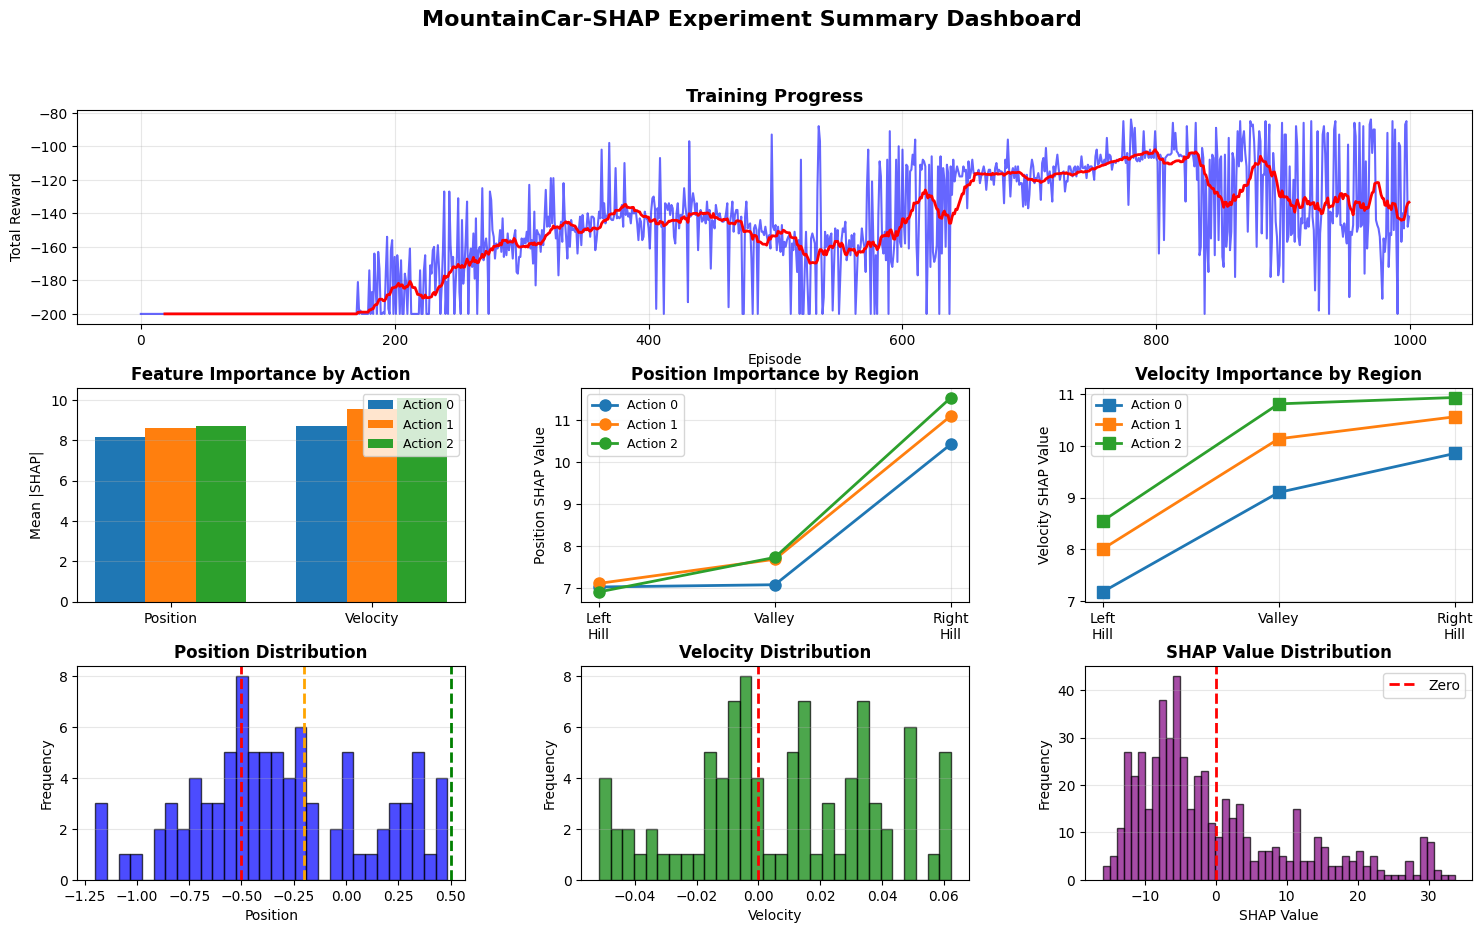

In [ ]:
print("="*80)
print("MountainCar-SHAP 실험 종합 분석")
print("="*80)

print("\n📊 실험 요약:")
print(f"  - 학습 에피소드: {num_episodes}")
print(f"  - 최종 평균 보상: {np.mean(episode_rewards[-100:]):.2f}")
print(f"  - 성공률 (최근 100 에피소드): {sum(1 for r in episode_rewards[-100:] if r > -200)/100*100:.1f}%")
print(f"  - 분석한 상태 수: {len(all_samples)}")

print("\n🔍 SHAP 분석 주요 발견사항:")

# 1. Feature 중요도 순위
print("\n1. 전체 Feature 중요도 (평균 절대 SHAP value):")
overall_importance = np.mean([np.mean(np.abs(all_shap_values[a]), axis=0)
                              for a in range(action_dim)], axis=0)
for idx in np.argsort(overall_importance)[::-1]:
    print(f"   {idx+1}. {feature_names[idx]}: {overall_importance[idx]:.4f}")

# 2. Action별 특성
print("\n2. Action별 의사결정 패턴:")
for action_idx in range(action_dim):
    action_importance = np.mean(np.abs(all_shap_values[action_idx]), axis=0)
    dominant_feature = feature_names[np.argmax(action_importance)]
    print(f"   {action_names[action_idx]}:")
    print(f"     - 가장 중요한 feature: {dominant_feature}")
    print(f"     - Position 중요도: {action_importance[0]:.4f}")
    print(f"     - Velocity 중요도: {action_importance[1]:.4f}")

# 3. 위치별 전략
print("\n3. 위치별 의사결정 전략:")
regions_analysis = [
    ("왼쪽 언덕", mean_shap_left),
    ("골짜기", mean_shap_valley),
    ("오른쪽 언덕", mean_shap_right)
]

for region_name, mean_shap in regions_analysis:
    print(f"\n   {region_name}:")
    # 각 영역에서 가장 자주 선택되는 action
    region_mask = {
        "왼쪽 언덕": all_samples[:, 0] < -0.5,
        "골짜기": (all_samples[:, 0] >= -0.5) & (all_samples[:, 0] < -0.2),
        "오른쪽 언덕": all_samples[:, 0] >= -0.2
    }[region_name]

    region_states = all_samples[region_mask]
    if len(region_states) > 0:
        region_actions = [np.argmax(wrapped_model(s.reshape(1, -1))[0])
                         for s in region_states]
        action_counts = [region_actions.count(a) for a in range(action_dim)]
        dominant_action = np.argmax(action_counts)

        print(f"     - 주로 선택되는 action: {action_names[dominant_action]} "
              f"({action_counts[dominant_action]/len(region_actions)*100:.1f}%)")
        print(f"     - 주요 고려 feature: ", end="")

        # 해당 action에서 이 영역의 평균 SHAP 확인
        feat_importance = mean_shap[dominant_action]
        dominant_feat = np.argmax(feat_importance)
        print(f"{feature_names[dominant_feat]} (SHAP: {feat_importance[dominant_feat]:.4f})")

# 4. SHAP의 특징
print("\n4. SHAP 방법론의 특징:")
print("   ✓ 게임 이론 기반으로 공정한 feature 기여도 측정")
print("   ✓ Feature 간 상호작용 고려")
print("   ✓ Model-agnostic (어떤 모델에도 적용 가능)")
print("   ✗ 계산 비용이 높음 (많은 샘플 필요)")

# 5. 실용적 활용
print("\n5. 실용적 활용 방안:")
print("   - 에이전트의 의사결정 검증 및 디버깅")
print("   - 위험 상황에서의 의사결정 근거 설명")
print("   - Feature engineering 방향성 제시")
print("   - 모델 신뢰성 평가")

print("\n" + "="*80)
print("✅ 실험 완료!")
print("="*80)

# 최종 시각화: 요약 대시보드
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. 학습 곡선
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(episode_rewards, alpha=0.6, color='blue')
window = 20
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
ax1.plot(range(window-1, len(episode_rewards)), moving_avg, 'r-', linewidth=2)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Training Progress', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Feature 중요도 비교
ax2 = fig.add_subplot(gs[1, 0])
x = np.arange(len(feature_names))
width = 0.25
for i, action_idx in enumerate(range(action_dim)):
    importance = np.mean(np.abs(all_shap_values[action_idx]), axis=0)
    ax2.bar(x + i*width, importance, width, label=action_names[action_idx].split(':')[0])
ax2.set_xticks(x + width)
ax2.set_xticklabels(feature_names)
ax2.set_ylabel('Mean |SHAP|')
ax2.set_title('Feature Importance by Action', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# 3. 위치별 전략
ax3 = fig.add_subplot(gs[1, 1])
region_names_short = ['Left\nHill', 'Valley', 'Right\nHill']
for action_idx in range(action_dim):
    values = [regions_analysis[i][1][action_idx, 0] for i in range(3)]
    ax3.plot(region_names_short, values, marker='o', linewidth=2,
            label=action_names[action_idx].split(':')[0], markersize=8)
ax3.set_ylabel('Position SHAP Value')
ax3.set_title('Position Importance by Region', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. 속도별 전략
ax4 = fig.add_subplot(gs[1, 2])
for action_idx in range(action_dim):
    values = [regions_analysis[i][1][action_idx, 1] for i in range(3)]
    ax4.plot(region_names_short, values, marker='s', linewidth=2,
            label=action_names[action_idx].split(':')[0], markersize=8)
ax4.set_ylabel('Velocity SHAP Value')
ax4.set_title('Velocity Importance by Region', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# 5. State 분포
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(all_samples[:, 0], bins=30, alpha=0.7, color='blue', edgecolor='black')
ax5.axvline(x=-0.5, color='red', linestyle='--', linewidth=2)
ax5.axvline(x=-0.2, color='orange', linestyle='--', linewidth=2)
ax5.axvline(x=0.5, color='green', linestyle='--', linewidth=2)
ax5.set_xlabel('Position')
ax5.set_ylabel('Frequency')
ax5.set_title('Position Distribution', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 6. Velocity 분포
ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(all_samples[:, 1], bins=30, alpha=0.7, color='green', edgecolor='black')
ax6.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax6.set_xlabel('Velocity')
ax6.set_ylabel('Frequency')
ax6.set_title('Velocity Distribution', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

# 7. SHAP 분포
ax7 = fig.add_subplot(gs[2, 2])
all_shap_flat = np.concatenate([all_shap_values[a].flatten() for a in range(action_dim)])
ax7.hist(all_shap_flat, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax7.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
ax7.set_xlabel('SHAP Value')
ax7.set_ylabel('Frequency')
ax7.set_title('SHAP Value Distribution', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

plt.suptitle('MountainCar-SHAP Experiment Summary Dashboard',
             fontsize=16, fontweight='bold')
plt.show()